In [2]:
import matplotlib
%matplotlib inline
import os
import time
import datetime
import json
from datetime import datetime
from time import gmtime, strftime
from random import randint
import re
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import pandas as pd
from psaw import PushshiftAPI
import csv

pd.set_option('display.max_colwidth', -1) # We want all comment text visible in notebook

# List of subreddits
subreddits = ["coronavirus"]
searchwords = ["covid", "corona", "sars-cov-2", "2019-ncov", "pandemic", "epidemic", "outbreak", "pneumonia", "illness", "disease", "sickness", "virus", "germ", "bacteria", "influenza", "symptom", "infect", "transmit"]

# Convert from epoch to Y-M-D
def timeInvert(epoch):
    return time.strftime('%Y-%m-%d', time.localtime(epoch))
# Convert to epoch from Y-M-D
def timeConvert(date):
    utc_time = datetime.strptime(date, "%Y-%m-%d")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return int(epoch_time)

# Fetch using psaw
def fetch(_searchword, _subreddit, _after, _before):
    api =  PushshiftAPI()
    gen =  api.search_comments(q=_searchword, 
                               subreddit=_subreddit,
                               #limit=100,
                               after=_after,
                               before=_before
                               #,filter=['body','created_utc']
                               )
    return list(gen)

# CREATE DATE TUPLES:
years = ["2020", "2021"]
startList = []
dateTuples = []
for year in years:
    for i in ["%.2d" % i for i in range(1,13)]:
        startList.append(year + "-" + i + "-01")        

for idx, date in enumerate(startList[:-1]):
    #dateTuples.append((date, startList[idx+1]))
    dateTuples.append((timeConvert(date), timeConvert(startList[idx+1])))

dateTuples = dateTuples[:13] # LIMIT DATES FROM JAN1 2020 TO FEB1 2020:


In [ ]:
# The crawler:
# Crawls subreddit for each searchword in list between dates and saves to dataframe
# Dataframe then pickled for later use
# The crawler finished in 36693sec / ~10 hours

df = pd.DataFrame()
includedColumns = ["author", "body", "created_utc", "id", "searchword"]
start = time.time()

for searchword in searchwords:
    for subreddit in subreddits:
        for period in dateTuples:
            print("Seachword: " + searchword)
            print("Between dates: " + timeInvert(period[0]) + " and " + str(timeInvert(period[1])))
            filename = "data/" + timeInvert(period[0]) + ".txt"
            comments = fetch(searchword, subreddit, period[0], period[1])
            print("Found " + str(len(comments)) + " comments \n")
            cleanedComments = [comment.d_["body"] for comment in comments]
            
            tempdf = pd.DataFrame([comment.d_ for comment in comments])
            tempdf['searchword'] = pd.Series(searchword, index=tempdf.index)
            
            if df.empty:
                df = tempdf
            else:
                df = pd.concat([df,tempdf], axis=0).reset_index(drop=True)
                #df = df.loc[df.astype(str).drop_duplicates().index]
                df = df.groupby(includedColumns[:-1])['searchword'].apply(lambda x: ','.join(x)).reset_index()
                df.to_pickle("df")

end = time.time()
print("Finished in: " + str(end - start))


In [3]:
# LOAD:
df = pd.read_pickle("df")

In [ ]:
#### Initial Comment Cleaning - Removes quotes, urls/reddit links
pattern = re.compile('\[(.*?)\]\(.*?\)') # regex pattern for removing links
def initialCommentClean(_comment):
    s = "\n".join([e if '&g' not in e else "" for e in _comment.splitlines()]) # Remove quotes
    s = pattern.sub(r'\1', s) # Remove links with hyperlink text, return the text instead
    s = "\n".join([e if 'http' not in e and '/r/' not in e else "" for e in s.splitlines()]) # Remove normal and reddit links
    #s = s.replace("\n", " ")
    s = " ".join(s.splitlines())
    return s

# Updates rows after cleaning (searchword from 'searchwords' column, if no keywords are present in 'body')
def updateRow(_df):
    return ",".join([e for e in _df["searchword"].split(',') if e in _df["body"].lower()])

#newDf = df.copy() # Create copy of original df
newDf = df.copy()

newDf = newDf[newDf['author'].apply(lambda x: x != "AutoModerator")] # Remove automoderator posts
newDf['id2'] = newDf.groupby(['author']).ngroup() # Create unique id instead of authorname
newDf['body'] = newDf['body'].map(lambda x: initialCommentClean(x)) # Apply initialclean method to comments
newDf['searchword'] = newDf.apply(updateRow, axis=1) # Remove searchword from 'searchwords' if removed from 'body'
newDf = newDf[newDf['searchword'].apply(lambda x: len(x) > 0)] # Remove rows where all 'searcwords' has been removed

# Save comments to .csv file
#newDf[:10].body.to_csv('outfile2.csv', index=False)

# Save Comments to .txt file:
#with open('newfile.txt', 'w', encoding='utf-8') as f:
#    for text in newDf['body'].tolist():
#        f.write(text + '\n')


In [4]:
# Save Comments to .txt file:
with open('newfile.txt', 'w', encoding='utf-8') as f:
    for text in newDf['body'].tolist():
        f.write(text + '\n')

In [55]:
# Create local keyness analysis with scores
warterms = pd.read_csv("data/warterms.csv", 
                  sep=';', 
                  names=["Word", "fwpm", "rwpm"])

#warterms['fwpm'] = warterms['fwpm'].astype(float)
N = 1 # 
warterms["KeynessScore"] = (warterms['fwpm']+N) / (warterms['rwpm']+N)
warterms.to_csv("data/warterms_withKeynessSores.csv", sep=';')
warterms



,Word,fwpm,rwpm,KeynessScore
0,fight,260.97,146.45,1.776670
1,force,206.90,282.51,0.733307
2,attack,168.85,167.73,1.006638
3,war,128.64,270.16,0.478094
4,threat,121.06,64.41,1.866076
5,struggle,67.80,79.09,0.859034
6,military,65.14,126.45,0.518949
7,combat,41.64,35.61,1.164709
8,defend,36.28,42.99,0.847465
9,battle,35.61,93.22,0.388559


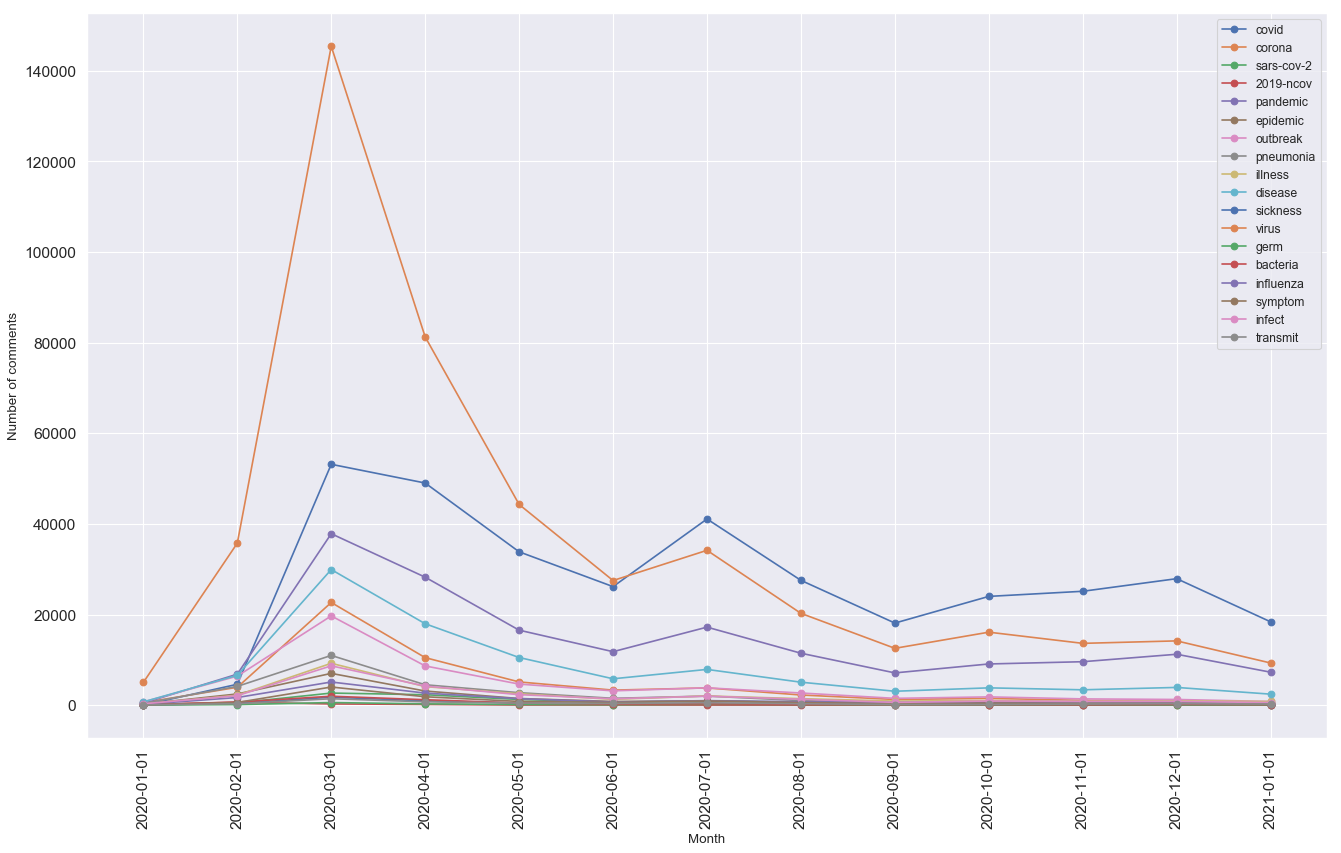

In [59]:
# Calculate number of comments each month for each searchword
# Create df to store this information in
# Create plot
# Save to csv for excel

numberOfComments = []

for tup in dateTuples:
    numberOfComments.append(len(newDf.loc[(newDf['created_utc'] >= tup[0]) & (newDf['created_utc'] <= tup[1])]))   
    
           
commentFrequency = {}        
for searchword in searchwords:
    monthly = []
    for tup in dateTuples:
        monthly.append(len(newDf.loc[(newDf['created_utc'] >= tup[0]) & (newDf['created_utc'] <= tup[1]) & (newDf['searchword'].str.contains(searchword))]))
    commentFrequency[searchword] = monthly

times = [timeInvert(e[0]) for e in dateTuples]
import seaborn as sns
sns.set(color_codes=True)
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

x = [e for e in range(len(dateTuples))]
plt.xticks(x, times)

plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.ylabel('Number of comments')
plt.xlabel('Month')
for searchword in searchwords:
    plt.plot(commentFrequency[searchword],label=searchword, linestyle='-', marker='o')
plt.legend()


with open('monthlycomments.csv','w') as file:
    for row in commentFrequency:
        file.write(row+";"+";".join(str(commentFrequency[row])))
        file.write('\n')



commentFrequencyDf = pd.DataFrame(commentFrequency)
commentFrequencyDf.to_csv("monthlyComments.csv", sep=';')